NLTK wordnet not found. Downloading...
Wordnet downloaded.
--- Starting Data Exploration and Preprocessing ---


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset loaded successfully.
Dataset shape: (50000, 2)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB

First 5 rows of the dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Missing values per column:
review       0
sentiment    0
dtype: int64

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Percentage of positive reviews: 50.00%
Percentag

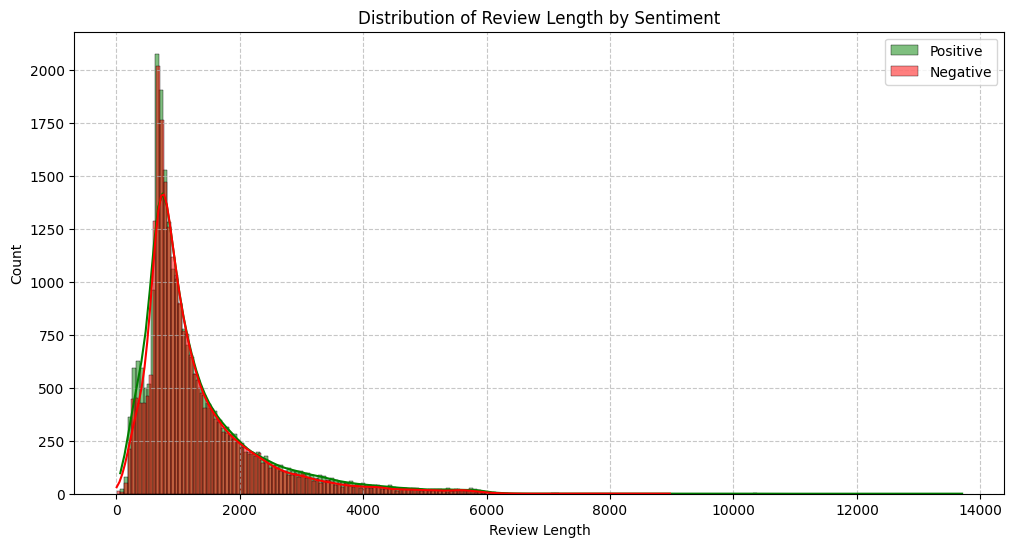


Applying text preprocessing...


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [12]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Ensure NLTK resources are downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("NLTK stopwords not found. Downloading...")
    nltk.download('stopwords')
    print("Stopwords downloaded.")

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("NLTK wordnet not found. Downloading...")
    nltk.download('wordnet')
    print("Wordnet downloaded.")

try:
    # Check if punkt_tab is available, which is part of the 'punkt' package
    nltk.data.find('tokenizers/punkt/english.pickle')
except LookupError:
    print("NLTK punkt not found. Downloading...")
    nltk.download('punkt')
    print("Punkt downloaded.")


# --- 1. Data Exploration and Preprocessing ---

print("--- Starting Data Exploration and Preprocessing ---")

# Load the dataset
try:
    df = pd.read_csv('Imdb - data_imdb.csv', engine='python', quotechar='"')
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'Imdb - data_imdb.csv' not found. Please ensure the file is in the correct directory.")
    exit()
except pd.errors.ParserError as e:
    print(f"Parser Error: {e}")
    print("Could not parse the CSV file. Please check the file format for issues like unescaped quotes.")
    exit()


# Display basic information
print("\nDataset Info:")
df.info()

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check for class imbalance in 'sentiment'
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())
print(f"Percentage of positive reviews: {df['sentiment'].value_counts(normalize=True)['positive']:.2%}")
print(f"Percentage of negative reviews: {df['sentiment'].value_counts(normalize=True)['negative']:.2%}")

# Analyze review length
df['review_length'] = df['review'].apply(len)
print("\nReview length statistics:")
print(df['review_length'].describe())

# Visualize review length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df[df['sentiment'] == 'positive']['review_length'], color='green', kde=True, label='Positive')
sns.histplot(df[df['sentiment'] == 'negative']['review_length'], color='red', kde=True, label='Negative')
plt.title('Distribution of Review Length by Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- Text Preprocessing Function ---
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and special characters, keep only alphanumeric
    # Tokenization
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in word_tokenize(re.sub(r'[^a-zA-Z\s]', '', text)) if word not in stop_words]
    # Join tokens back into a string
    return ' '.join(tokens)

print("\nApplying text preprocessing...")
df['cleaned_review'] = df['review'].apply(preprocess_text)
print("Text preprocessing completed.")
print("\nSample of cleaned reviews:")
print(df[['review', 'cleaned_review']].head())

# --- 2. Feature Engineering ---

print("\n--- Starting Feature Engineering ---")

# Textual features: Word count, character count, average word length
df['word_count'] = df['cleaned_review'].apply(lambda x: len(x.split()))
df['char_count'] = df['cleaned_review'].apply(len)
df['avg_word_length'] = df['cleaned_review'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)

print("\nAdded textual features (word_count, char_count, avg_word_length).")
print(df[['cleaned_review', 'word_count', 'char_count', 'avg_word_length']].head())

# Visualize word count distribution
plt.figure(figsize=(12, 6))
sns.histplot(df[df['sentiment'] == 'positive']['word_count'], color='green', kde=True, label='Positive')
sns.histplot(df[df['sentiment'] == 'negative']['word_count'], color='red', kde=True, label='Negative')
plt.title('Distribution of Word Count by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# TF-IDF Vectorization
print("\nPerforming TF-IDF Vectorization...")
# Initialize TF-IDF Vectorizer. max_features can be tuned.
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_review'])

# Combine TF-IDF features with textual features
# For simplicity, let's just use TF-IDF for now as it's the primary textual feature.
# Combining numerical features with TF-IDF would require converting X_tfidf to a DataFrame
# or using a feature union, which can be more complex for initial demonstration.
# X = np.hstack((X_tfidf.toarray(), df[['word_count', 'char_count', 'avg_word_length']].values))
X = X_tfidf
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0) # Convert sentiment to numerical (0 for negative, 1 for positive)

print(f"TF-IDF features shape: {X.shape}")
print("Feature Engineering completed.")

# Generate Word Cloud for positive reviews
positive_reviews_text = " ".join(df[df['sentiment'] == 'positive']['cleaned_review'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_reviews_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Generate Word Cloud for negative reviews
negative_reviews_text = " ".join(df[df['sentiment'] == 'negative']['cleaned_review'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_reviews_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()


# --- 3. Model Development ---

print("\n--- Starting Model Development ---")

# Split data into training and testing sets
# Using a stratify split to maintain the same proportion of target classes in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data shape (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Testing data shape (X_test, y_test): {X_test.shape}, {y_test.shape}")

# Initialize and train Logistic Regression model
print("\nTraining Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
lr_model.fit(X_train, y_train)
print("Logistic Regression model trained.")

# Initialize and train Multinomial Naive Bayes model
print("\nTraining Multinomial Naive Bayes model...")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
print("Multinomial Naive Bayes model trained.")


# --- 4. Model Evaluation ---

print("\n--- Starting Model Evaluation ---")

models = {
    "Logistic Regression": lr_model,
    "Multinomial Naive Bayes": nb_model
}

for name, model in models.items():
    print(f"\nEvaluating {name} Model:")
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

print("\n--- Model Evaluation Completed ---")

# --- 5. Example Prediction (Optional) ---
print("\n--- Demonstrating Example Prediction ---")
new_reviews = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "Utterly terrible film, a complete waste of time and money. Do not watch.",
    "It was okay, not great, not bad, just average.",
    "The acting was superb, but the plot was a bit weak."
]

print("\nOriginal Reviews:")
for review in new_reviews:
    print(f"- {review}")

# Preprocess new reviews
cleaned_new_reviews = [preprocess_text(review) for review in new_reviews]

# Transform new reviews using the trained TF-IDF vectorizer
X_new = tfidf_vectorizer.transform(cleaned_new_reviews)

print("\nPredictions using Logistic Regression:")
for i, review_text in enumerate(new_reviews):
    prediction = lr_model.predict(X_new[i])
    sentiment = "Positive" if prediction[0] == 1 else "Negative"
    print(f"Review: '{review_text}'\nPredicted Sentiment: {sentiment}\n")

print("\nPredictions using Multinomial Naive Bayes:")
for i, review_text in enumerate(new_reviews):
    prediction = nb_model.predict(X_new[i])
    sentiment = "Positive" if prediction[0] == 1 else "Negative"
    print(f"Review: '{review_text}'\nPredicted Sentiment: {sentiment}\n")

print("\n--- Project Execution Completed ---")